## Deploy Mphasis DeepInsights Text Pre-Processor Model Package from AWS Marketplace 

Text Pre-processor solution is an efficient way of automatically cleaning text data to make it ready for further text analytics. The model takes a corpus of text as input file and an optional Stop_Words file for customised stop words removal and applies NLP techniques to generate a processed output containing tokenized words, lemmas, noun chunks and geographical locations present in the corpus with their frequency of occurrences. This solution also generates treemap plots for most frequent words and geographical location with their corresponding frequency in the cleaned text.

This sample notebook shows you how to deploy Mphasis DeepInsights Text Pre-Processor using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to Mphasis DeepInsights Text Pre-Processor. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Output Result](#D.-Output-Result)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page Mphasis DeepInsights Text Pre-Processor
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [2]:
model_package_arn='arn:aws:sagemaker:us-east-2:786796469737:model-package/mphasis-deepinsights-text-cleaner-preprocessor-v01'

In [3]:
import pandas as pd
import numpy as np
import json
import re
import os
import boto3
from matplotlib import pyplot as plt
from zipfile import ZipFile
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from IPython.display import Image
from PIL import Image as ImageEdit

In [4]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-786796469737'

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [5]:
model_name='text-clean-preprocess'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.xlarge'
batch_transform_inference_instance_type='ml.m5.large'

#### A. Create an endpoint

In [8]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type=content_type)

#create a deployable model from the model package.

model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

In [ ]:
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

##### Input Format
The input is a Zip file.

<b>Note:</b> 

Input file from sage_maker should be of the form zip. Zipped file should atleast contain one .txt file with 'utf-8' encoding and must be named as 'Input.txt'.

For customised stop word removal another .txt can be given having corpus of stop words to be removed and must be named as Stop_Words.txt. For reference please refer the sample files.

##### Input Instructions

•	The input must be a zip file containing atleast one and max two ‘.txt’ file with ‘utf-8’ encoding.

•	Input corpus of text should be saved in 'Input.txt' file.

•	For customized stop word removal provide Stop_Words.txt file in zipped folder.

•	Maximum input file sizes : 35kb ( ~ 500 rows of text )


In [10]:
file_path = os.getcwd()
file_name = '.data/input/Input.zip'

file_object = open(file_name,'rb')
z = ZipFile(file_object)
file_names = []
for name in z.namelist():
    z.extract(name,file_path)
    file_names.append(name)
file_object.close()
print(file_names)

['Input.txt']


In [11]:
input_text = open('Input.txt','r')
print(input_text.read())

Barack Obama was inaugurated as the 44th president of the United States becoming the first African American to serve in that office on January 20, 2009. The son of a white American mother and a black Kenyan father, Obama grew up in Hawaii. Leaving the state to attend college, he earned degrees from Columbia University and Harvard Law School. Obama worked as a community organizer in Chicago, where he met and married Michelle LaVaughn Robinson in 1992. Their two daughters, Malia Ann and Natasha (Sasha), were born in 1998 and 2001, respectively. Obama was elected to the Illinois state senate in 1996 and served there for eight years. In 2004, he was elected by a record majority to the US Senate from Illinois and, in February 2007, announced his candidacy for president. After winning a closely fought contest against New York Senator and former First Lady Hillary Rodham Clinton for the Democratic nomination, Obama handily defeated Senator John McCain of Arizona, the Republican nominee for pr

##### Optional 
Run only when optional Stop_Word.txt file is zippen in the Input.

In [ ]:
input_Stop_Words = open('Stop_Words.txt','r')
print(input_Stop_Words.read())

In [13]:
output_file_name = 'output.zip'

#### C. Perform real-time inference

In [14]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $model_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    $output_file_name

{
    "ContentType": "application/zip",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Output Result

Let us process the output.

Supported Content type: `application/zip`

    - Output file is of zip format and contains 3 files.
    - The first file is Output.csv containing Word, Lemma, Noun_Chunk and Location with their corresponding frequency of    occurrence in the cleaned data.
    - The second file is a treemap plot 'Word_Plot.png' depicting top ten frequent words with percentage of occurrence in    the cleaned data.
    - The third file is a tremap plot 'GEO_Plot.png' depiction top ten frequent geographical locations with percentage of   occurrence in the cleaned data.

In [15]:
with ZipFile('.data/output/output.zip', 'r') as zipObj:
    zipObj.extractall()

In [16]:
Output = pd.read_csv('Output.csv')
Output.drop(['Unnamed: 0'], axis = 1)

,Word,Word_Frequency,Lemma,Lemma_Frequency,Noun_Chunk,Noun_Chunk_Frequency,Location,GEO_Frequency
0,Obama,12.0,Obama,12.0,United States,2.0,Illinois,3.0
1,president,6.0,president,6.0,President Obama,2.0,Chicago,2.0
2,Republicans,3.0,term,4.0,Illinois state senate,1.0,US,2.0
3,term,3.0,win,4.0,Barack Obama,1.0,Iraq,2.0
4,Illinois,3.0,control,3.0,gun control,1.0,Afghanistan,1.0
...,...,...,...,...,...,...,...,...
187,NaN,NaN,outgoing,1.0,NaN,NaN,NaN,NaN
188,NaN,NaN,take,1.0,NaN,NaN,NaN,NaN
189,NaN,NaN,nominee,1.0,NaN,NaN,NaN,NaN
190,NaN,NaN,young,1.0,NaN,NaN,NaN,NaN


In [17]:
Image_Word_Plot = Image(filename = 'Word_Plot.png')

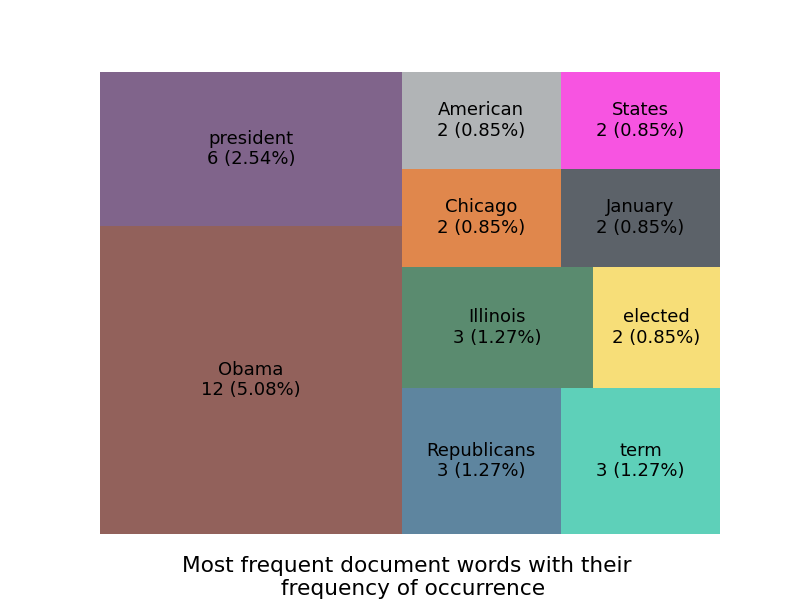

In [18]:
Image_Word_Plot

In [19]:
Image_GEO_Plot = Image(filename='GEO_Plot.png')

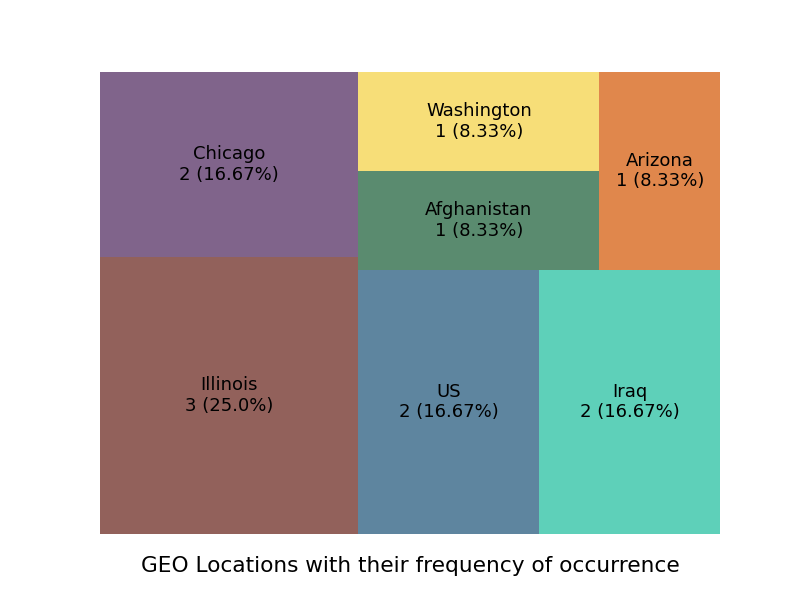

In [20]:
Image_GEO_Plot

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [21]:
predictor=sage.predictor.Predictor(model_name, sagemaker_session,content_type)
predictor.delete_endpoint(delete_endpoint_config=True)

### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [ ]:
import json 
import uuid


transformer = model.transformer(1, 'ml.m5.large')
transformer.transform('s3://mphasis-marketplace/text_clean_preprocess/Input.zip', content_type='application/zip')
transformer.wait()
#transformer.output_path
print("Batch Transform complete")
bucketFolder = transformer.output_path.rsplit('/')[3]

In [23]:
#print(s3bucket,s3prefix)
s3_conn = boto3.client("s3")
bucket_name="sagemaker-us-east-2-786796469737"
with open('output.zip', 'wb') as f:
    s3_conn.download_fileobj(bucket_name, bucketFolder+'/Input.zip.out', f)
    print("Output file loaded from bucket")

Output file loaded from bucket


In [24]:
with ZipFile('.data/output/output.zip', 'r') as zipObj:
    zipObj.extractall()

In [25]:
Output = pd.read_csv('Output.csv')
Output.drop(['Unnamed: 0'], axis = 1)

,Word,Word_Frequency,Lemma,Lemma_Frequency,Noun_Chunk,Noun_Chunk_Frequency,Location,GEO_Frequency
0,Obama,12.0,Obama,12.0,President Obama,2.0,Illinois,3.0
1,president,6.0,president,6.0,United States,2.0,Iraq,2.0
2,term,3.0,term,4.0,care reform legislation,1.0,US,2.0
3,Illinois,3.0,win,4.0,Senator John McCain,1.0,Chicago,2.0
4,Republicans,3.0,control,3.0,Obama Presidential Center,1.0,Arizona,1.0
...,...,...,...,...,...,...,...,...
188,NaN,NaN,York,1.0,NaN,NaN,NaN,NaN
189,NaN,NaN,Malia,1.0,NaN,NaN,NaN,NaN
190,NaN,NaN,bail,1.0,NaN,NaN,NaN,NaN
191,NaN,NaN,Middle,1.0,NaN,NaN,NaN,NaN


In [26]:
Image_Word_Plot = Image(filename = 'Word_Plot.png')

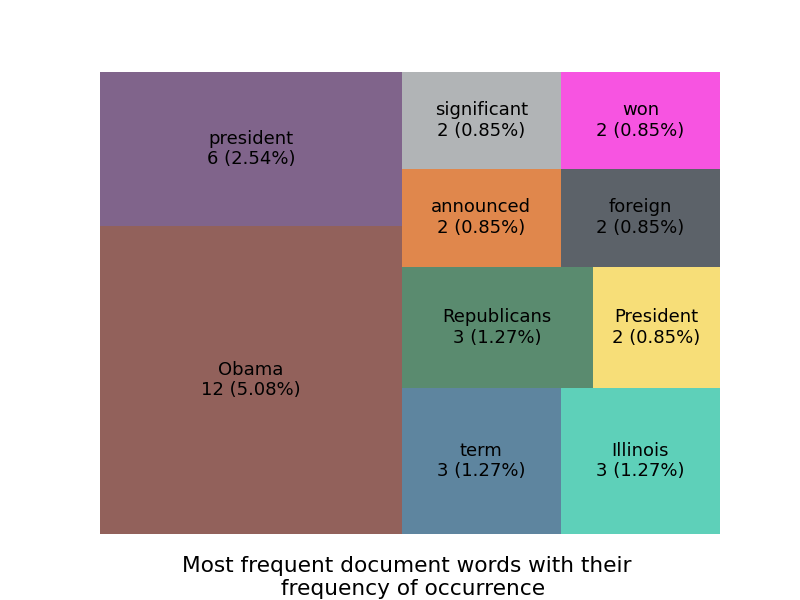

In [27]:
Image_Word_Plot

In [28]:
Image_GEO_Plot = Image(filename='GEO_Plot.png')

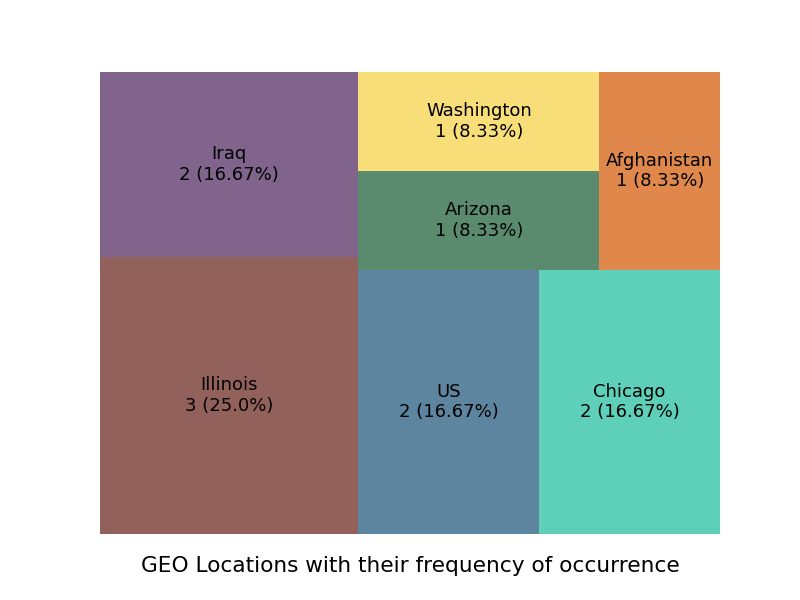

In [29]:
Image_GEO_Plot

### 4. Clean-up

#### A. Delete the model

In [30]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.